```plain
split
video_uid
    clip_uid
    video_start_sec
    video_end_sec
    video_start_frame
    video_end_frame
    clip_start_sec
    clip_end_sec
    clip_start_frame
    clip_end_frame
        annotation_uid
        request_uid
            video_start_sec
            video_end_sec
            video_start_frame
            video_end_frame
            clip_start_sec
            clip_end_sec
            template
            query
            slot_x
            verb_x
            slot_y
            verb_y
```

In [251]:
%cd /data/gunsbrother/prjs/ltvu/tasks/Ego4D

import re
import json
import uuid
from pathlib import Path

import pandas as pd

target_keypairs = {
    'videos': [
        # ['split', 'split'],
        ['video_uid', 'video_uid'],
    ],
    'clips': [
        ['clip_uid', 'clip_uid'],
        ['video_start_sec', 'video_start_sec'],
        ['video_end_sec', 'video_end_sec'],
        ['video_start_frame', 'video_start_frame'],
        ['video_end_frame', 'video_end_frame'],
        ['clip_start_sec', 'clip_start_sec'],
        ['clip_end_sec', 'clip_end_sec'],
        ['clip_start_frame', 'clip_start_frame'],
        ['clip_end_frame', 'clip_end_frame'],
    ],
    'annotations': [
        ['annotation_uid', 'annotation_uid'],
        # ['request_uid', 'request_uid'],  # valid에만 있음
    ],
    'language_queries': [
        ['video_start_sec', 'q_video_start_sec'],
        ['video_end_sec', 'q_video_end_sec'],
        ['video_start_frame', 'q_video_start_frame'],
        ['video_end_frame', 'q_video_end_frame'],
        ['clip_start_sec', 'q_clip_start_sec'],
        ['clip_end_sec', 'q_clip_end_sec'],
        ['template', 'template'],
        ['query', 'query'],
        ['slot_x', 'slot_x'],
        ['verb_x', 'verb_x'],
        ['slot_y', 'slot_y'],
        ['verb_y', 'verb_y'],
    ]
}

def get_from_keypairs(obj: dict, keypairs: list[str], default=None):
    result = {}
    for key_from, key_to in keypairs:
        value = obj.get(key_from, default)
        if isinstance(value, str):
            if is_nullable_string(value):
                value = None
            else:
                value = polish_string(value)
        elif isinstance(value, float):
            value = round(value, 8)
        result[key_to] = value
    return result

def is_nullable_string(s):
    null_patterns = [
        'not_applicable',
        'not_in_list',
        r'^[eE]mpty.?\s*$'
    ]
    for null_pattern in null_patterns:
        if match := re.search(null_pattern, s):
            found_text = match.group()
            return True
    return False

def lower_excluding_standalones(s):
    excluded_chars = ['I', 'X', 'Y']
    s = s.lower()
    for char in excluded_chars:
        s = re.sub(r'\b' + char.lower() + r'\b', char, s)
    return s

def polish_string(s):
    replace_patterns = [
        [r'[XY] (Text|Verb) \(Optional\):\s*', ''],
        [r'\s*\?\s*$', '?'],
        [r' +', ' '],
        ['Query Text:', ''],
    ]
    s = s.strip()
    for replace_pattern, to in replace_patterns:
        s = re.sub(replace_pattern, to, s)
    s = lower_excluding_standalones(s)
    return s

def generate_uuid_from_string(s: str):
    return uuid.uuid5(uuid.NAMESPACE_URL, s)

FPS = 30
def get_frames_from_second(sec: float, fps: int = FPS, eps: float = 1e-5):
    num_frames = int(sec * fps + eps)  # trim small seconds as considering them as a camera delay
    return num_frames

def calibrate_secs(row, fps: int = FPS):
    for mode in ['video', 'clip']:
        row[f'{mode}_start_frame'] = get_frames_from_second(row[f'{mode}_start_sec'], fps)
        tmp_end_frame = get_frames_from_second(row[f'{mode}_end_sec'], fps)
        if tmp_end_frame - row[f'{mode}_start_frame'] in [14399, 14401]:
            tmp_end_frame = row[f'{mode}_start_frame'] + 14400
        row[f'{mode}_end_frame'] = tmp_end_frame
        # quantize secs based on the number of frames
        row[f'{mode}_start_sec'] = row[f'{mode}_start_frame'] / fps
        row[f'{mode}_end_sec'] = row[f'{mode}_end_frame'] / fps
    return row


dfs = []
for version in ['v1', 'v2']:
    for split in ['train', 'val']:
        if version == 'v1':
            p_json = Path(f'/data/gunsbrother/repos/EgoVLPv2/EgoNLQ/jsons/nlq_{split}.json')
        elif version == 'v2':
            p_json = Path(f'annotations/nlq_{split}.json')
        data = json.load(p_json.open())

        records = []
        for video in data['videos']:
            row_video = get_from_keypairs(video, target_keypairs['videos'])
            video_uid = row_video['video_uid']
            for clip in video['clips']:
                clip = calibrate_secs(clip)
                row_clip = get_from_keypairs(clip, target_keypairs['clips'])
                clip_uid = row_clip['clip_uid']
                row_clip['duration_sec'] = round(row_clip['video_end_sec'] - row_clip['video_start_sec'], 8)
                # video_X_frame은 개같음
                # row_clip['duration_frame'] = row_clip['video_end_frame'] - row_clip['video_start_frame'] + 1
                row_clip['duration_frame'] = row_clip['clip_end_frame'] - row_clip['clip_start_frame'] + 1
                for annotation in clip['annotations']:
                    row_annotation = get_from_keypairs(annotation, target_keypairs['annotations'])
                    annotation_uid = row_annotation['annotation_uid']
                    for idx_q, language_query in enumerate(annotation['language_queries']):
                        language_query = calibrate_secs(language_query)
                        row_language_query = get_from_keypairs(language_query, target_keypairs['language_queries'])
                        if 'query' not in row_language_query or not row_language_query['query']:
                            continue
                        if not row_language_query['query'].endswith('?'):
                            row_language_query['query'] = row_language_query['query'] + '?'
                        row_language_query['q_clip_start_frame'] = row_language_query['q_video_start_frame'] - row_clip['video_start_frame']
                        row_language_query['q_clip_end_frame'] = row_language_query['q_video_end_frame'] - row_clip['video_start_frame']
                        row_language_query['q_duration_sec'] = round(row_language_query['q_video_end_sec'] - row_language_query['q_video_start_sec'], 8)
                        row_language_query['q_duration_frame'] = row_language_query['q_video_end_frame'] - row_language_query['q_video_start_frame'] + 1
                        row_language_query['q_coverage'] = row_language_query['q_duration_frame'] / row_clip['duration_frame']
                        row_language_query['query_idx'] = idx_q
                        uuid_string = f'{idx_q} {video_uid} {clip_uid} {annotation_uid} {row_language_query["query"]}'
                        row_language_query['q_uid'] = generate_uuid_from_string(uuid_string)
                        records.append({**row_video, **row_clip, **row_annotation, **row_language_query})

        df = pd.DataFrame.from_records(records)
        df.to_csv(f'EgoNLQ/csvs/nlq_{split}_{version}.csv', index=False)
        dfs.append(df)
df.iloc[-5:]

/data/gunsbrother/prjs/ltvu/tasks/Ego4D


,video_uid,clip_uid,video_start_sec,video_end_sec,video_start_frame,video_end_frame,clip_start_sec,clip_end_sec,clip_start_frame,clip_end_frame,...,verb_x,slot_y,verb_y,q_clip_start_frame,q_clip_end_frame,q_duration_sec,q_duration_frame,q_coverage,query_idx,q_uid
4547,50b2fa2f-9d39-4b9c-8e3c-4a4ef0669956,38a0d090-c67f-4197-b2a6-65cb56c356c5,0.0,480.0,0,14400,0.0,480.0,0,14400,...,put,None,None,7190,7370,6.0,181,1.3e-02,3,884efdbe-6d2c-509c-bff8-58f3bd935aac
4548,50b2fa2f-9d39-4b9c-8e3c-4a4ef0669956,38a0d090-c67f-4197-b2a6-65cb56c356c5,0.0,480.0,0,14400,0.0,480.0,0,14400,...,wipe,None,None,8770,8920,5.0,151,1.0e-02,4,212fd776-7720-5378-aef2-2a4d2ad205b4
4549,50b2fa2f-9d39-4b9c-8e3c-4a4ef0669956,38a0d090-c67f-4197-b2a6-65cb56c356c5,0.0,480.0,0,14400,0.0,480.0,0,14400,...,pick,None,None,9115,9145,1.0,31,2.2e-03,5,ccdacd86-1d80-5062-b14b-51ed1201b50f
4550,50b2fa2f-9d39-4b9c-8e3c-4a4ef0669956,38a0d090-c67f-4197-b2a6-65cb56c356c5,0.0,480.0,0,14400,0.0,480.0,0,14400,...,pick,None,None,9259,9529,9.0,271,1.9e-02,6,e6fc2537-934e-509f-81fd-aab06bdcba4b
4551,50b2fa2f-9d39-4b9c-8e3c-4a4ef0669956,38a0d090-c67f-4197-b2a6-65cb56c356c5,0.0,480.0,0,14400,0.0,480.0,0,14400,...,put,None,None,11281,11311,1.0,31,2.2e-03,7,77eb5ff0-38f9-5df1-b4d7-4d495fc29892


In [17]:
dfs[0][dfs[0]['q_uid'].duplicated()]

,video_uid,clip_uid,video_start_sec,video_end_sec,video_start_frame,video_end_frame,clip_start_sec,clip_end_sec,clip_start_frame,clip_end_frame,...,template,query,slot_x,verb_x,slot_y,verb_y,q_duration_sec,q_duration_frame,q_coverage,q_uid


In [18]:
dfs[1][dfs[1]['q_uid'].duplicated()]

,video_uid,clip_uid,video_start_sec,video_end_sec,video_start_frame,video_end_frame,clip_start_sec,clip_end_sec,clip_start_frame,clip_end_frame,...,template,query,slot_x,verb_x,slot_y,verb_y,q_duration_sec,q_duration_frame,q_coverage,q_uid


<Axes: >

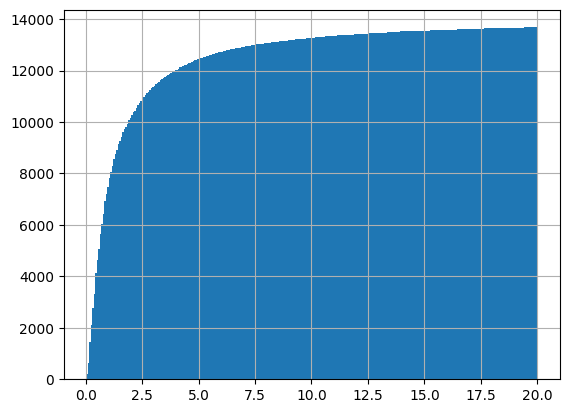

In [74]:
df = dfs[0]
(100*df['q_coverage'])[df['q_coverage'] < .2].hist(bins=300, cumulative=True, density=False)

# 스탬프는 `q_video_sec`나 `q_video_frame` 써야 할 듯
### $\Rightarrow$ 보통 `video_start_sec` 쓰더라

In [53]:
df = dfs[0]
diffs = {}
for src in ['q_video', 'q_clip']:
    for unit in ['sec', 'frame']:
        key_e = f'{src}_end_{unit}'
        if key_e not in df:
            continue
        diffs[f'{src}_{unit}'] = df[key_e] - df[f'{src}_start_{unit}']
        if unit == 'frame':
            diffs[f'{src}_{unit}'] /= 30
diffs = pd.DataFrame(diffs)
diffdiffs = diffs.sub(diffs.mean(axis=1), axis=0)
diffs = pd.concat([diffs, diffdiffs], axis=1)
print(diffs[(diffdiffs.std(axis=1) > .3)].abs().max(axis=0))
diffs[(diffdiffs.std(axis=1) > .3)]

q_video_sec      414.135858
q_video_frame    414.133333
q_clip_sec       418.699530
q_video_sec        1.520670
q_video_frame      1.522907
q_clip_sec         3.043290
dtype: float64


,q_video_sec,q_video_frame,q_clip_sec,q_video_sec,q_video_frame,q_clip_sec
6573,13.210850,13.200000,13.80985,-0.196050,-0.206900,0.402950
6574,5.615880,5.600000,6.21488,-0.194373,-0.210253,0.404627
9680,4.214667,4.200000,4.73400,-0.168222,-0.182889,0.351111
10313,90.168328,90.166667,94.73200,-1.520670,-1.522332,3.043002
10331,414.135858,414.133333,418.69953,-1.520382,-1.522907,3.043290


# Statistics

```plain
# clips
avg. clip len.
# queries
avg. GT len.
avg. cover.
```

In [3]:
%cd /data/gunsbrother/prjs/ltvu/tasks/Ego4D

import pandas as pd
from pathlib import Path

records = []
dfs_egonlq = []
for version in ['v1', 'v2']:
    dfs = []
    for split in ['train', 'val', 'overall']:
        index = f'{version} {split}'
        print(index)
        if split != 'overall':
            p_csv = Path(f'EgoNLQ/csvs/nlq_{split}_{version}.csv')
            df = pd.read_csv(p_csv)
            dfs.append(df)
        else:
            df = pd.concat(dfs, axis=0)
            dfs_egonlq.append(df)
        df_clips = df.drop_duplicates(subset=['clip_uid'])
        clip_lengths = df_clips['duration_sec']
        df_display = records.append({
            'version': version,
            'split': split,
            '# clips': df_clips.shape[0],
            'avg. clip len.': clip_lengths.mean(),
            '# queries': df.shape[0],
            'avg. GT len.': df['q_duration_sec'].mean(),
            'avg. cover.': 100*df['q_coverage'].mean(),
        })
pd.set_option('display.precision', 1)
pd.DataFrame.from_records(records).set_index(['version', 'split'])

/data/gunsbrother/prjs/ltvu/tasks/Ego4D
v1 train
v1 val
v1 overall
v2 train
v2 val
v2 overall


# clips  avg. clip len.  # queries  avg. GT len.  avg. cover.
version split                                                                 
v1      train        998           493.8      11291           9.7          2.0
        val          328           498.9       3874           9.0          1.9
        overall     1326           495.0      15165           9.5          1.9
v2      train       1270           493.8      13847          11.3          2.3
        val          415           499.7       4552          10.7          2.2
        overall     1685           495.3      18399          11.2          2.3

In [60]:
df_v1clips = dfs_egonlq[1][['video_uid', 'clip_uid']].drop_duplicates().reset_index(drop=True)
exists = []
for clip_uid in df_v1clips['clip_uid']:
    p_clip = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official/') / f'{clip_uid}.mp4'
    exists.append(p_clip.exists())
df_v1clips['exists'] = exists
df_v1clips[~df_v1clips['exists']]

,video_uid,clip_uid,exists
3,9d09f4f8-4ea1-4989-8f6d-8965c4f4fe69,04199001-307a-40fd-b20c-4b4128546b89,False
1207,73eb69c9-762a-4ec6-999b-73ca4210a7ba,70a350cd-4f32-40ed-80dd-23a48e7c4e46,False


# Charades-STA

In [1]:
import json
import pandas as pd
from pathlib import Path

p_json_dir = Path('/data/gunsbrother/prjs/ltvu/baselines/cpl/data/charades')
records = []
dfs = []
df_csta = None
for split in ['train', 'test', 'overall']:
    if split != 'overall':
        p_json = p_json_dir / f'{split}.json'
        annotations = json.load(p_json.open())
        split_records = []
        for uid, duration, (start_sec, end_sec), caption in annotations:
            split_record = {
                'clip_uid': uid,
                'duration_sec': duration,
                'q_duration_sec': end_sec - start_sec,
                'q_coverage': (end_sec - start_sec) / duration
            }
            split_records.append(split_record)
        df = pd.DataFrame.from_records(split_records)
        dfs.append(df)
    else:
        df = pd.concat(dfs, axis=0)
        df_csta = df
    df_clips = df.drop_duplicates(subset=['clip_uid'])
    clip_lengths = df_clips['duration_sec']
    record = {
        'split': split,
        '# clips': df_clips.shape[0],
        'avg. clip len.': clip_lengths.mean(),
        '# queries': df.shape[0],
        'avg. GT len.': df['q_duration_sec'].mean(),
        'avg. cover.': 100*df['q_coverage'].mean() ,
    }
    records.append(record)
pd.DataFrame.from_records(records).set_index(['split'])

,# clips,avg. clip len.,# queries,avg. GT len.,avg. cover.
split,,,,,
train,4842,31.089632,10602,8.258089,26.985032
test,1225,29.536106,3158,7.902248,27.199961
overall,6067,30.775957,13760,8.176422,27.034359


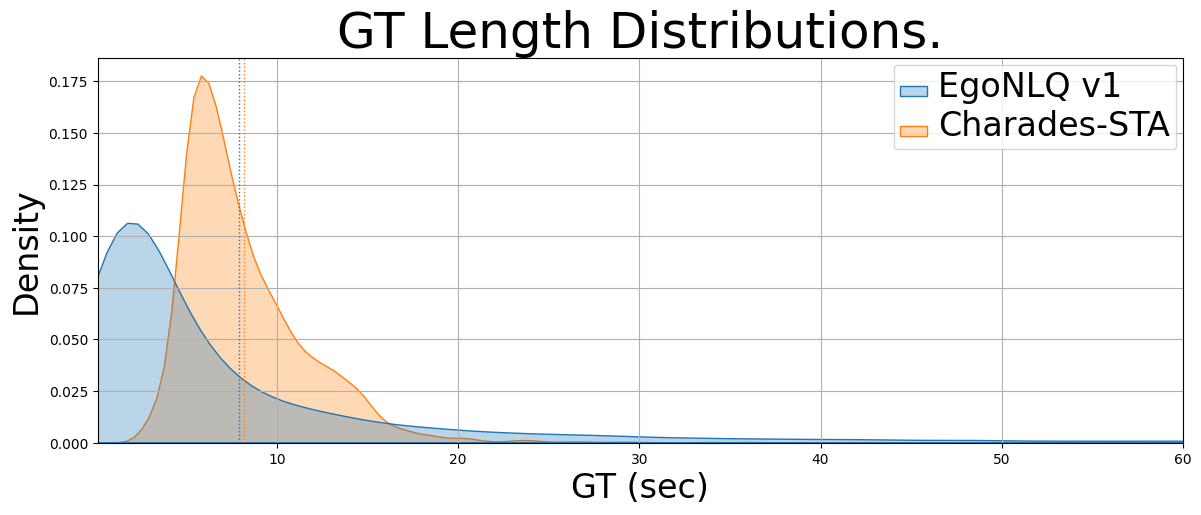

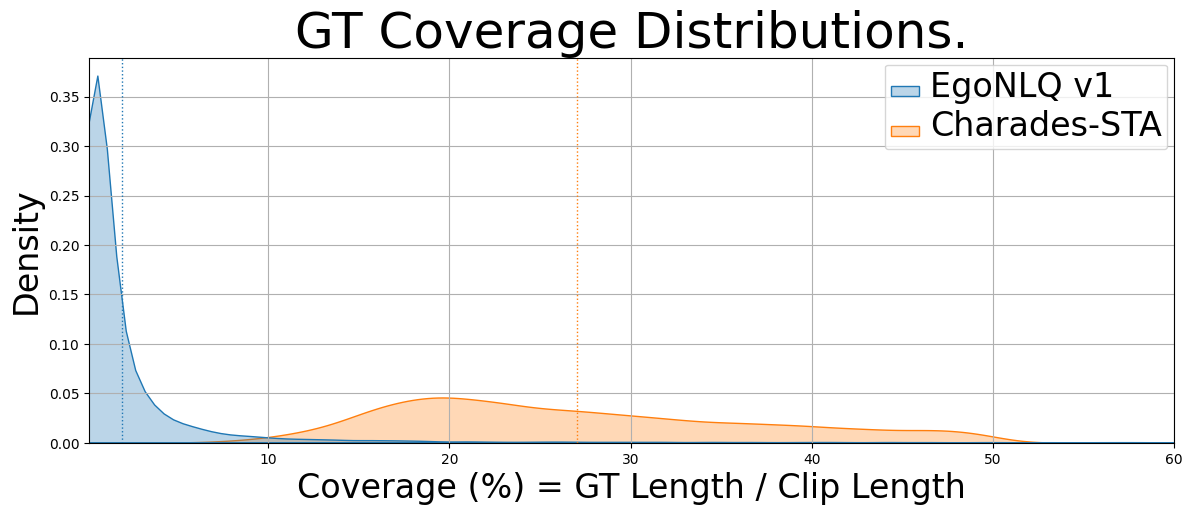

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fontsize_title = 36
fontsize_label = 24
fontsize_legend = 24

##################################################################

q_lengths_egonlq = dfs_egonlq[0]['q_duration_sec']
q_lengths_egonlq = q_lengths_egonlq[q_lengths_egonlq < 103]
df_hist = pd.DataFrame({
    'EgoNLQ v1': q_lengths_egonlq.reset_index(drop=True),
    'Charades-STA': df_csta['q_duration_sec'].reset_index(drop=True),
})

fig, ax = plt.subplots(figsize=(14, 5))
# sns.histplot(df_hist, ax=ax, element='poly', log_scale=False, cumulative=False, common_norm=False, stat='density')
sns.kdeplot(df_hist, ax=ax, fill=True, common_norm=False, alpha=.3, linewidth=1.)
ax.set_title('GT Length Distributions.', fontsize=fontsize_title)
plt.xlabel('GT (sec)', fontsize=fontsize_label)
plt.ylabel('Density', fontsize=fontsize_label)
line_kwargs = dict(ls=':', lw=1)
plt.axvline(x=df_hist['EgoNLQ v1'].mean(), color=sns.color_palette()[0], **line_kwargs)
plt.axvline(x=df_hist['Charades-STA'].mean(), color=sns.color_palette()[1], **line_kwargs)
plt.setp(ax.get_legend().get_texts(), fontsize=fontsize_legend)
plt.grid()
plt.xlim(.1, 60)
plt.show()

##################################################################

df_egonlq_v1 = dfs_egonlq[0]
df_egonlq_v1_filtered = df_egonlq_v1[['duration_sec', 'q_coverage']].reset_index(drop=True)
df_csta_filtered = df_csta[['duration_sec', 'q_coverage']].reset_index(drop=True)
df_joint = pd.concat(
    [df_egonlq_v1_filtered, df_csta_filtered],
    keys=['EgoNLQ v1', 'Charades-STA'],
    names=['Dataset']
).droplevel(1).reset_index()
df_joint['q_coverage'] *= 100
df_joint = pd.DataFrame({
    'EgoNLQ v1': df_joint[df_joint['Dataset'] == 'EgoNLQ v1']['q_coverage'],
    'Charades-STA': df_joint[df_joint['Dataset'] == 'Charades-STA']['q_coverage'],
})

fig, ax = plt.subplots(figsize=(14, 5))
sns.kdeplot(df_joint, ax=ax, fill=True, common_norm=False, alpha=.3, linewidth=1.)
ax.set_title('GT Coverage Distributions.', fontsize=fontsize_title)
plt.xlabel('Coverage (%) = GT Length / Clip Length', fontsize=fontsize_label)
plt.ylabel('Density', fontsize=fontsize_label)
line_kwargs = dict(ls=':', lw=1)
plt.axvline(x=df_joint['EgoNLQ v1'].mean(), color=sns.color_palette()[0], **line_kwargs)
plt.axvline(x=df_joint['Charades-STA'].mean(), color=sns.color_palette()[1], **line_kwargs)
plt.setp(ax.get_legend().get_texts(), fontsize=fontsize_legend)
plt.grid()
plt.xlim(.1, 60)
plt.show()

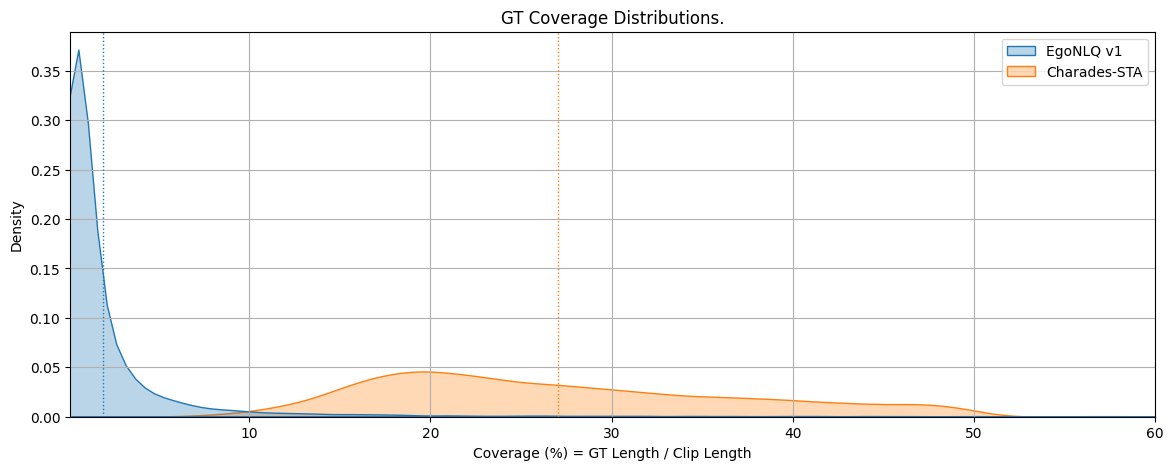

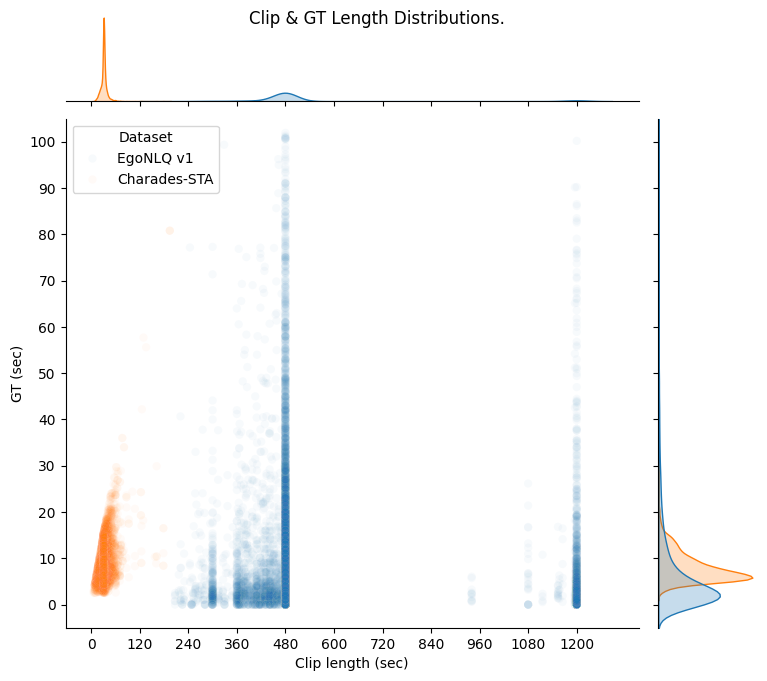

In [247]:
df_egonlq_v1 = dfs_egonlq[0]
df_egonlq_v1_filtered = df_egonlq_v1[df_egonlq_v1['q_duration_sec']<103][['duration_sec', 'q_duration_sec']].reset_index(drop=True)
df_csta_filtered = df_csta[['duration_sec', 'q_duration_sec']].reset_index(drop=True)
df_joint = pd.concat(
    [df_egonlq_v1_filtered, df_csta_filtered],
    keys=['EgoNLQ v1', 'Charades-STA'],
    names=['Dataset']
).droplevel(1).reset_index()
sns.jointplot(df_joint, x='duration_sec', y='q_duration_sec', hue='Dataset', joint_kws=dict(alpha=.03))
plt.gcf().set_size_inches(8, 7)
plt.xticks(list(range(0, 1201, 120)))
plt.yticks(list(range(0, 101, 10)))
plt.xlabel('Clip length (sec)')
plt.ylabel('GT (sec)')
plt.suptitle('Clip & GT Length Distributions.')
plt.ylim(-5, 105)
plt.show()

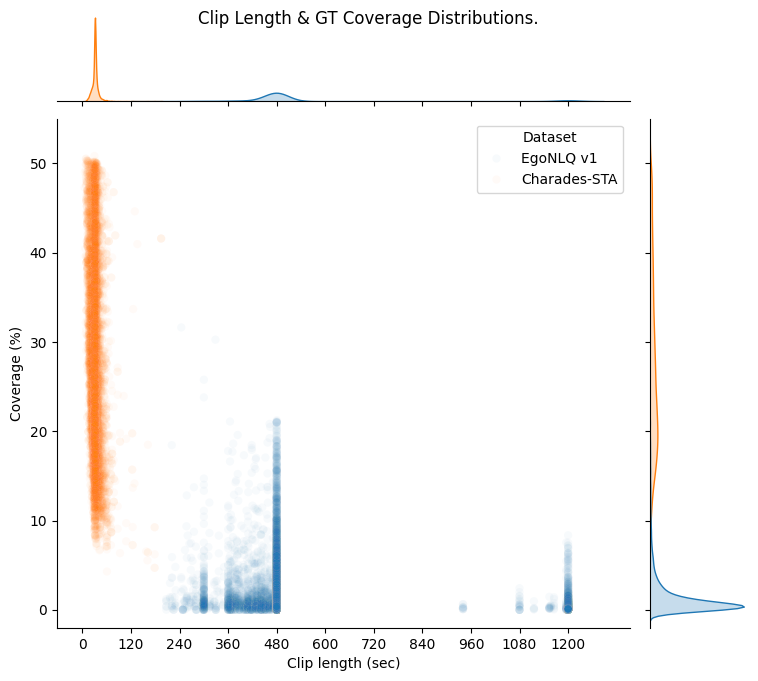

In [248]:
df_egonlq_v1 = dfs_egonlq[0]
df_egonlq_v1_filtered = df_egonlq_v1[df_egonlq_v1['q_duration_sec']<103][['duration_sec', 'q_coverage']].reset_index(drop=True)
df_csta_filtered = df_csta[['duration_sec', 'q_coverage']].reset_index(drop=True)
df_joint = pd.concat(
    [df_egonlq_v1_filtered, df_csta_filtered],
    keys=['EgoNLQ v1', 'Charades-STA'],
    names=['Dataset']
).droplevel(1).reset_index()
df_joint['q_coverage'] *= 100
sns.jointplot(df_joint, x='duration_sec', y='q_coverage', hue='Dataset', joint_kws=dict(alpha=.03))
plt.gcf().set_size_inches(8, 7)
plt.xticks(list(range(0, 1201, 120)))
# plt.yticks(list(range(0, 101, 10)))
plt.xlabel('Clip length (sec)')
plt.ylabel('Coverage (%)')
plt.suptitle('Clip Length & GT Coverage Distributions.')
plt.ylim(-2, 55)
plt.show()